In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import seaborn as sns
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.model_selection   import cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics           import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
import string
import re
from itertools import islice
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import balanced_accuracy_score


# Importing dataset

In [18]:
#importing file from the url
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Clothing_Shoes_and_Jewelry_5.json.gz

--2020-06-24 13:47:09--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Clothing_Shoes_and_Jewelry_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47285200 (45M) [application/x-gzip]
Saving to: ‘reviews_Clothing_Shoes_and_Jewelry_5.json.gz’

reviews_Clothing_Sh 100%[===================>]  45.09M  1.04MB/s    in 62s     

2020-06-24 13:48:12 (742 KB/s) - ‘reviews_Clothing_Shoes_and_Jewelry_5.json.gz’ saved [47285200/47285200]



In [78]:
file = 'reviews_Clothing_Shoes_and_Jewelry_5.json.gz'
df = pd.read_json(file, lines=True, compression='gzip')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014"


In [373]:
df.shape

(278677, 11)

# Data exploration (before cleaning)

In [79]:
#to include all information, we will use both review and summary information
df['full_text'] = df['reviewText'] + " " + df['summary']

In [80]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,full_text
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011",This is a great tutu and at a really great pri...
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013",I bought this for my 4 yr old daughter for dan...
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013",What can I say... my daughters have it in oran...
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014","We bought several tutus at once, and they are ..."
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014",Thank you Halo Heaven great product for Little...


In [81]:
#selecting only 2 columns for the model training
data = pd.concat([df['full_text'], df['overall'], df['summary']], axis=1)
data.head()

,full_text,overall,summary
0,This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made
1,I bought this for my 4 yr old daughter for dan...,5,Very Cute!!
2,What can I say... my daughters have it in oran...,5,I have buy more than one
3,"We bought several tutus at once, and they are ...",5,"Adorable, Sturdy"
4,Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it


In [9]:
#missing values checking
data.isna().sum()

full_text    0
overall      0
dtype: int64

In [10]:
data.isnull().values.any()

False

5    163240
4     58357
3     30425
2     15463
1     11192
Name: overall, dtype: int64


Text(0, 0.5, 'Number')

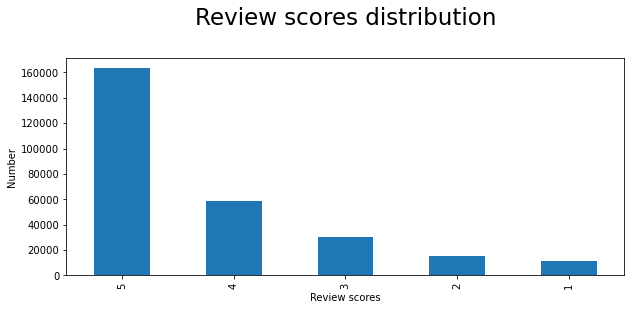

In [364]:
#Printing and visualisation the frequency distribution of the class attributes
distr = data['overall'].value_counts()
print(distr)
plt.figure(figsize=(10,4))
distr.plot(kind='bar')
plt.title('Review scores distribution', fontsize = 23, pad = 33)

plt.xlabel('Review scores')
plt.ylabel('Number')

In [88]:
#counting the number of words in each sentence
data['word_number'] = data['full_text'].apply(lambda x: len(x.split(' ')))
data.head()

,full_text,overall,summary,cleaned,cleaned_summary,word_number
0,This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,great tutu really great price doesnt look chea...,great tutu cheaply made,41
1,I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,bought yr old daughter dance class wore today ...,cute,63
2,What can I say... my daughters have it in oran...,5,I have buy more than one,say daughters orange black white pink thinking...,buy one,68
3,"We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",bought several tutus got high reviews sturdy s...,adorable sturdy,78
4,Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,thank halo heaven great product little girls g...,grammys angels love,91


In [89]:
data['word_number'].describe()

count    278677.000000
mean         64.891997
std          63.136444
min           2.000000
25%          30.000000
50%          45.000000
75%          76.000000
max        3943.000000
Name: word_number, dtype: float64

In [90]:
gr = data.groupby('overall')['word_number'].agg([np.min, np.max, np.mean, np.median])
gr

,amin,amax,mean,median
overall,,,,
1,2,869,69.333006,50
2,3,1343,71.295932,52
3,2,3943,69.981495,51
4,2,2216,70.251898,49
5,2,2170,61.116185,42


In [91]:
print('Average word length of phrases is {0:.0f}.'.format(np.mean(data['full_text'].apply(lambda x: len(x.split())))))

Average word length of phrases is 64.


Text(0.5, 1.0, 'Word number distribution within each category')

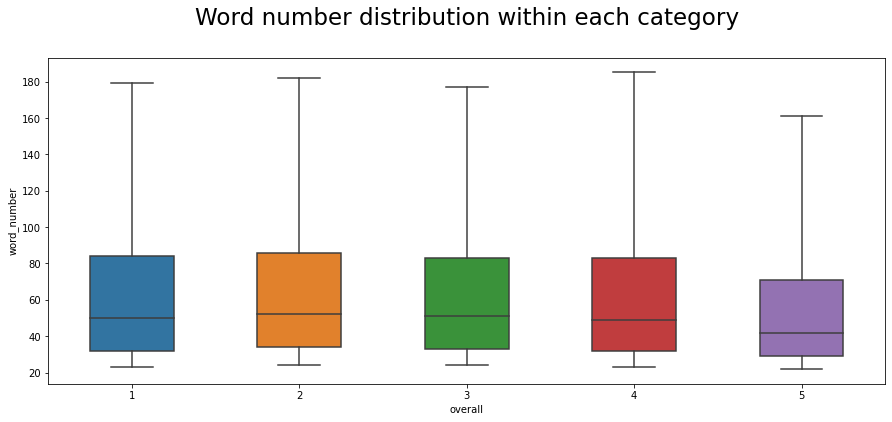

In [96]:

plt.figure(figsize=(15,6))
sns.boxplot(data=data, x='overall', y='word_number', width=.5, showfliers=False, whis=[5,95])
plt.title('Word number distribution within each category', fontsize = 23, pad = 33)

Text(0.5, 1.0, 'Review length distribution within each category')

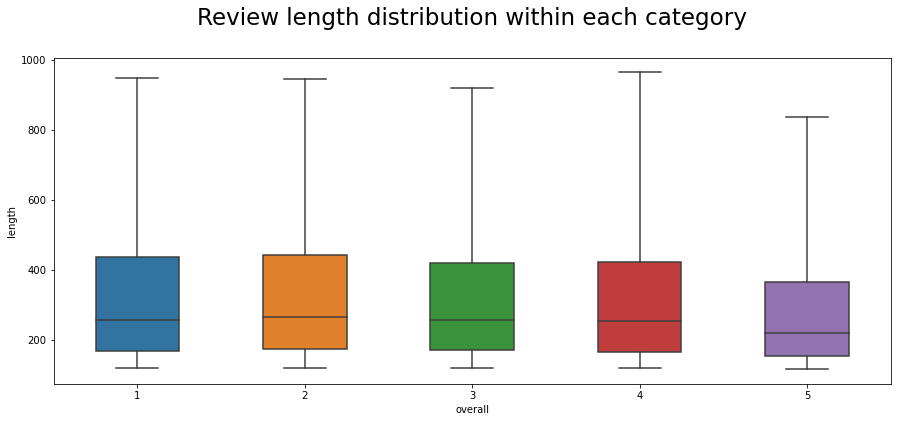

In [99]:
#exploring the length of each sentence
data['length'] = data['full_text'].str.len()
plt.figure(figsize=(15,6))

sns.boxplot(data=data, x='overall', y='length', width=.5, showfliers=False, whis=[5,95])
plt.title('Review length distribution within each category', fontsize = 23, pad = 33)

# Data cleaning

The data cleaning stage of the training dataset includes lowercase each word and remove punctuations, non-alphabetical symbols, stopwords and one-character words.

In [18]:
def clean_doc(doc):
    tokens = doc.split()
    tokens = [word.lower() for word in tokens]
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    return " ".join(tokens)

In [82]:
#cleaning the combined full text
data['cleaned'] = data['full_text'].apply(clean_doc)

In [85]:
#cleaning the summary
data['cleaned_summary'] = data['summary'].apply(clean_doc)

In [100]:
data.head(3)

,full_text,overall,summary,cleaned,cleaned_summary,word_number,length
0,This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,great tutu really great price doesnt look chea...,great tutu cheaply made,41,202
1,I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,bought yr old daughter dance class wore today ...,cute,63,318
2,What can I say... my daughters have it in oran...,5,I have buy more than one,say daughters orange black white pink thinking...,buy one,68,337


# Data exploration after cleaning

In [36]:
n = len(data["overall"].unique())

In [73]:
#in order to explore which words more associated with positive and negative review scores, 
#we assigned scores 4 and 5 as positive, and 1 and 2 as negative

pos1 = df[df['overall'] == 5]['cleaned_summary']
pos2 = df[df['overall'] == 4]['cleaned_summary']
neg1 = df[df['overall'] == 2]['cleaned_summary']
neg2 = df[df['overall'] == 1]['cleaned_summary']
pos = pd.concat([pos1, pos2])
neg = pd.concat([neg1, neg2])

In [69]:
#the function to filter words with occurrence more than 10
def occur(doc):
    vocab = Counter()
    vocab.update(doc)
    tokens = [k for k,c in vocab.items() if c >= 10]
    return ' '.join(str(i) for i in tokens)

In [74]:
tokens_pos = occur(pos)
tokens_neg = occur(neg)

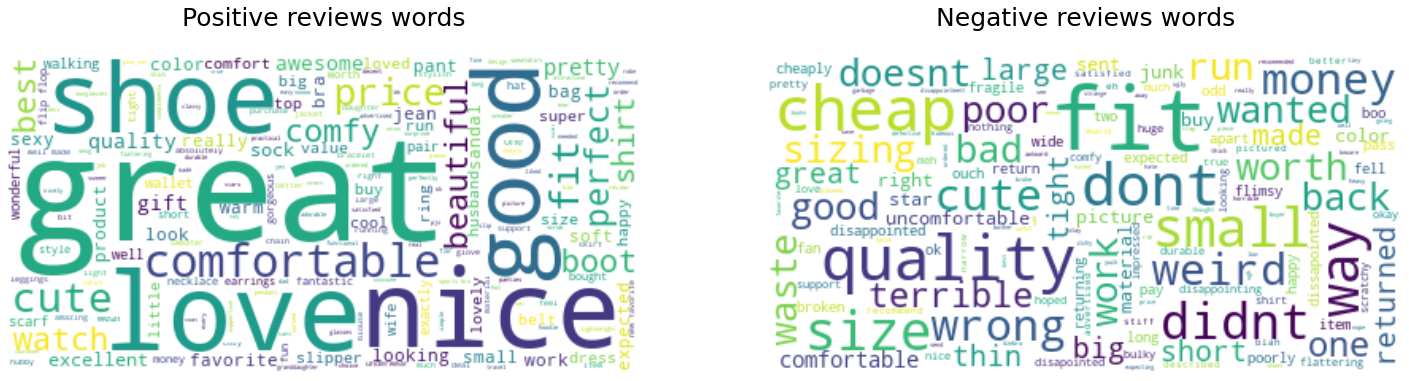

In [103]:
wordcloud = WordCloud(background_color="white",max_words=len(tokens_pos)).generate(tokens_pos)
wordcloud1 = WordCloud(background_color="white",max_words=len(tokens_pos)).generate(tokens_neg)

fig, ax = plt.subplots(1, 2, figsize=(25,25))

ax[0].imshow(wordcloud, interpolation='bilinear')
ax[1].imshow(wordcloud1, interpolation='bilinear')

ax[0].axis("off")
ax[0].set_title('Positive reviews words', fontsize="25",  y=1.08)

ax[1].axis("off")
ax[1].set_title('Negative reviews words', fontsize="25",  y=1.08)

plt.show()

Words for Score 1:


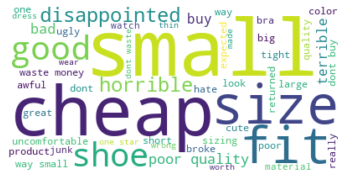

Words for Score 2:


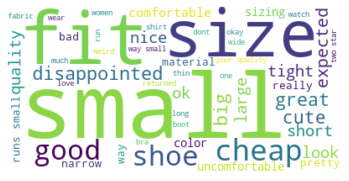

Words for Score 3:


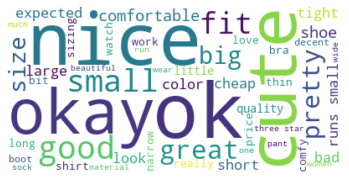

Words for Score 4:


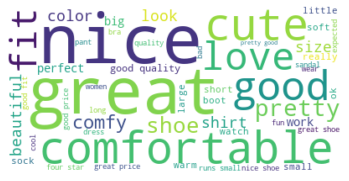

Words for Score 5:


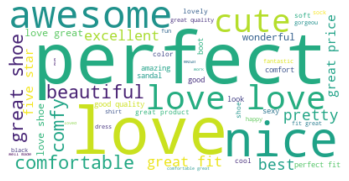

In [106]:
#alternatively, we also exlored the most associated words regarding each review score
for i in range(1, n+1):
    txt = data[data["overall"]==i]["cleaned_summary"] 
    collapsed_txt = txt.str.cat(sep=' ')
    wordcloud = WordCloud(background_color="white",max_words=50).generate(collapsed_txt)
    print("Words for Score {}:".format(i))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Dataset splitting

In [107]:
X_train, X_test, y_train, y_test = train_test_split(data["cleaned"], data["overall"],random_state = 42,test_size = 0.2)

In [108]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Baseline model - Logistic regression

In [110]:
#we trained Logistic regression model as baseline model
pipe = Pipeline([
    ('vec', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter = 7000)),
     ])

In [111]:
model = pipe.fit(X_train, y_train)

In [115]:
print("Accuracy of Logistic regression Classifier is {}".format(model.score(X_test,y_test)))

Accuracy of Logistic regression Classifier is 0.6924608870388976


Test dataset accuracy score: 0.6924608870388976 

Test dataset mean_squared_error score: 0.6519125879144538 

              precision    recall  f1-score   support

           1       0.61      0.46      0.52      2296
           2       0.39      0.26      0.31      3047
           3       0.47      0.39      0.43      6115
           4       0.52      0.37      0.43     11720
           5       0.78      0.92      0.85     32558

    accuracy                           0.69     55736
   macro avg       0.55      0.48      0.51     55736
weighted avg       0.66      0.69      0.67     55736



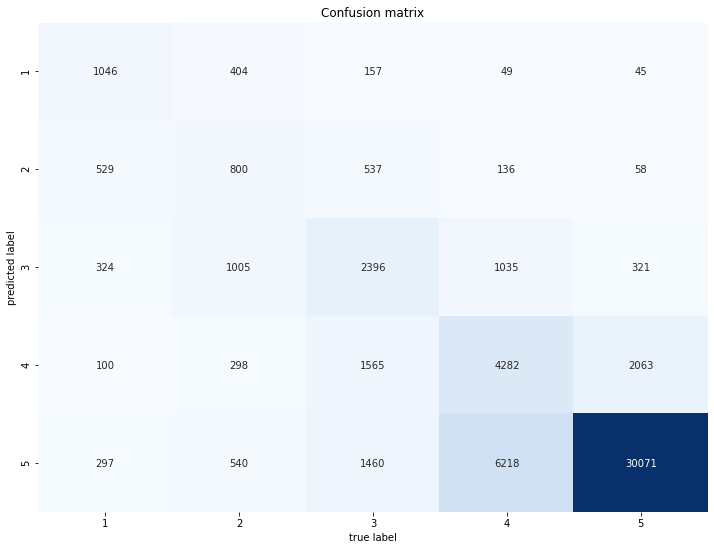

In [116]:
labels = list(set(data['overall']))

#prediction on the cleaned test dataset
y_pred = model.predict(X_test)

print('Test dataset accuracy score:', accuracy_score(y_test, y_pred),'\n')
print('Test dataset mean_squared_error score:', mean_squared_error(y_test, y_pred),'\n')

print(classification_report(y_test, y_pred, labels=labels))

con = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,9))
ax_cor_b = sns.heatmap(con.T, square=False, annot=True, fmt='d', cbar=False,
            xticklabels=labels, 
            yticklabels=labels,
            cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion matrix')
plt.show()

# Deep Learning model

In [2]:
import spacy
import re
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch
import torch.nn as nn

In [3]:
file = 'reviews_Clothing_Shoes_and_Jewelry_5.json.gz'
df2 = pd.read_json(file, lines=True, compression='gzip')
df2['full_text'] = df2['reviewText'] + " " + df2['summary']
df2.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,full_text
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011",This is a great tutu and at a really great pri...
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013",I bought this for my 4 yr old daughter for dan...
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013",What can I say... my daughters have it in oran...
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014","We bought several tutus at once, and they are ..."
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014",Thank you Halo Heaven great product for Little...


In [4]:
def clean_doc2(doc):
    tokens = doc.split()
    tokens = [word.lower() for word in tokens]
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
 #   stop_words = set(stopwords.words('english'))
 #   tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [5]:
#count number of occurences of each word
counts = Counter()
for index, row in df2.iterrows():
    counts.update(clean_doc2(row['full_text']))

In [6]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 160190
num_words after: 56746


In [7]:
vocab2index = {"":0, "UNK":1}
words = ["","UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [8]:
def encode(text, vocab2index=vocab2index, N=100):
    tokenized = clean_doc2(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded

In [9]:
df2['encoded'] = df2['full_text'].apply(lambda x: np.array(encode(x,vocab2index )))
df2.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,full_text,encoded
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011",This is a great tutu and at a really great pri...,"[2, 3, 4, 5, 6, 7, 8, 4, 9, 10, 11, 12, 13, 7,..."
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013",I bought this for my 4 yr old daughter for dan...,"[31, 2, 32, 33, 34, 35, 36, 32, 37, 38, 39, 40..."
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013",What can I say... my daughters have it in oran...,"[71, 72, 73, 33, 74, 75, 10, 76, 77, 78, 79, 6..."
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014","We bought several tutus at once, and they are ...","[103, 31, 104, 105, 7, 106, 6, 84, 107, 108, 1..."
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014",Thank you Halo Heaven great product for Little...,"[142, 143, 144, 145, 4, 146, 32, 95, 96, 33, 4..."


In [10]:
zero_numbering = {1:0, 2:1, 3:2, 4:3, 5:4}
df2['overall'] = df2['overall'].apply(lambda x: zero_numbering[x])

In [11]:
X = list(df2['encoded'])
y = list(df2['overall'])

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)

In [12]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
train_ds = ReviewsDataset(X_tr, y_tr)
valid_ds = ReviewsDataset(X_val, y_val)

In [14]:
batch_size = 5000
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [15]:
class GRUModel(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super(GRUModel,self).__init__()
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        out_pack, ht = self.gru(x)
        return self.linear(ht[-1])

In [16]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [17]:
def train_epochs(model, optimizer, train_dl, val_dl, epochs=10):
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x)
            optimizer.zero_grad()
#            loss = F.cross_entropy(y_pred, y)
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc = val_metrics(model, val_dl)
#        if i % 5 == 1:
        print(i, "epoch:", "train loss %.3f val loss %.3f and val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))


In [18]:
def val_metrics(model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for x, y in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total, correct/total

In [19]:
vocab_size = len(words)
print(vocab_size)

model = GRUModel(vocab_size, 100, 100)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

56748


In [20]:
train_epochs(model, optimizer, train_dl, valid_dl, epochs=10)

0 epoch: train loss 1.194 val loss 1.051 and val accuracy 0.591
1 epoch: train loss 0.891 val loss 0.764 and val accuracy 0.684
2 epoch: train loss 0.771 val loss 0.723 and val accuracy 0.702
3 epoch: train loss 0.734 val loss 0.708 and val accuracy 0.708
4 epoch: train loss 0.713 val loss 0.697 and val accuracy 0.712
5 epoch: train loss 0.697 val loss 0.692 and val accuracy 0.716
6 epoch: train loss 0.683 val loss 0.687 and val accuracy 0.716
7 epoch: train loss 0.674 val loss 0.689 and val accuracy 0.717
8 epoch: train loss 0.662 val loss 0.685 and val accuracy 0.719
9 epoch: train loss 0.652 val loss 0.684 and val accuracy 0.719
